In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

##### First, we need to load the csv files containing molecular descriptors. 

In [2]:
macrolides_df  = pd.read_csv('data/macrolides_2Drdkit.csv')
approved_df = pd.read_csv('data/ApprovedDrugs_20120615_2Drdkit.csv')
micro_df = pd.read_csv('data/MicrosourceSpectrum_2Drdkit.csv')

In [3]:
print('macrolides_df : ', macrolides_df.shape)
print('approved_df :', approved_df.shape)
print('micro_df :', micro_df.shape)

macrolides_df :  (137, 116)
approved_df : (1317, 116)
micro_df : (2141, 116)


#### Now Let's classify the datasets. We will add a column called 'dataset' and fill it with 
1) 'Macrolides' in 'macrolides_df' dataframe,
2) 'Approved Drugs' in 'approved_df' dataframe,
3) 'Microsource Spectrum' in 'micro_df' dataframe.

In [4]:
macrolides_df['dataset'] = 'Macrolides'
approved_df['dataset'] = 'Approved Drugs'
micro_df['dataset'] = 'Microsource Spectrum'

### We will then merge these four datasets into one pandas dataframe.

In [5]:
three_merged = pd.concat([macrolides_df, approved_df, micro_df])

In [6]:
three_merged.shape

(3595, 117)

### Before we apply PCA, let's process the data first. We will drop the columns that we won't need for the preprocessing like 'smiles' and 'dataset'.

In [7]:
df_descriptors = three_merged.drop(['smiles', 'dataset'], axis=1)

### Then, we will impute the missing values by replacing them with mean values from along each column. We will then then scale each column from 0 to 1.

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = MinMaxScaler()
transformed_X = scaler.fit_transform(imputer.fit_transform(df_descriptors))

#####  Now, we will apply feature extraction with PCA using scikit-learn library on this prepared numpy array. 

In [9]:
#PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(transformed_X)

three_merged['pca-one'] = pca_result[:,0]
three_merged['pca-two'] = pca_result[:,1] 
three_merged['pca-three'] = pca_result[:,2] 

for v in pca.explained_variance_ratio_:
    print('Explained variation per principal component: {}%'.format(round(v*100,2)))

Explained variation per principal component: 34.14%
Explained variation per principal component: 14.74%
Explained variation per principal component: 8.1%


### Let's double check how many unique values are in the "dataset" column. This is how we will color them separately in the PCA plots so we know what dataset covers which part of the chemical space.

In [10]:
three_merged['dataset'].unique()

array(['Macrolides', 'Approved Drugs', 'Microsource Spectrum'],
      dtype=object)

In [11]:
macrolides_df = three_merged[three_merged['dataset']== 'Macrolides']
approved_df = three_merged[three_merged['dataset']== 'Approved Drugs']
micro_df = three_merged[three_merged['dataset']== 'Microsource Spectrum']

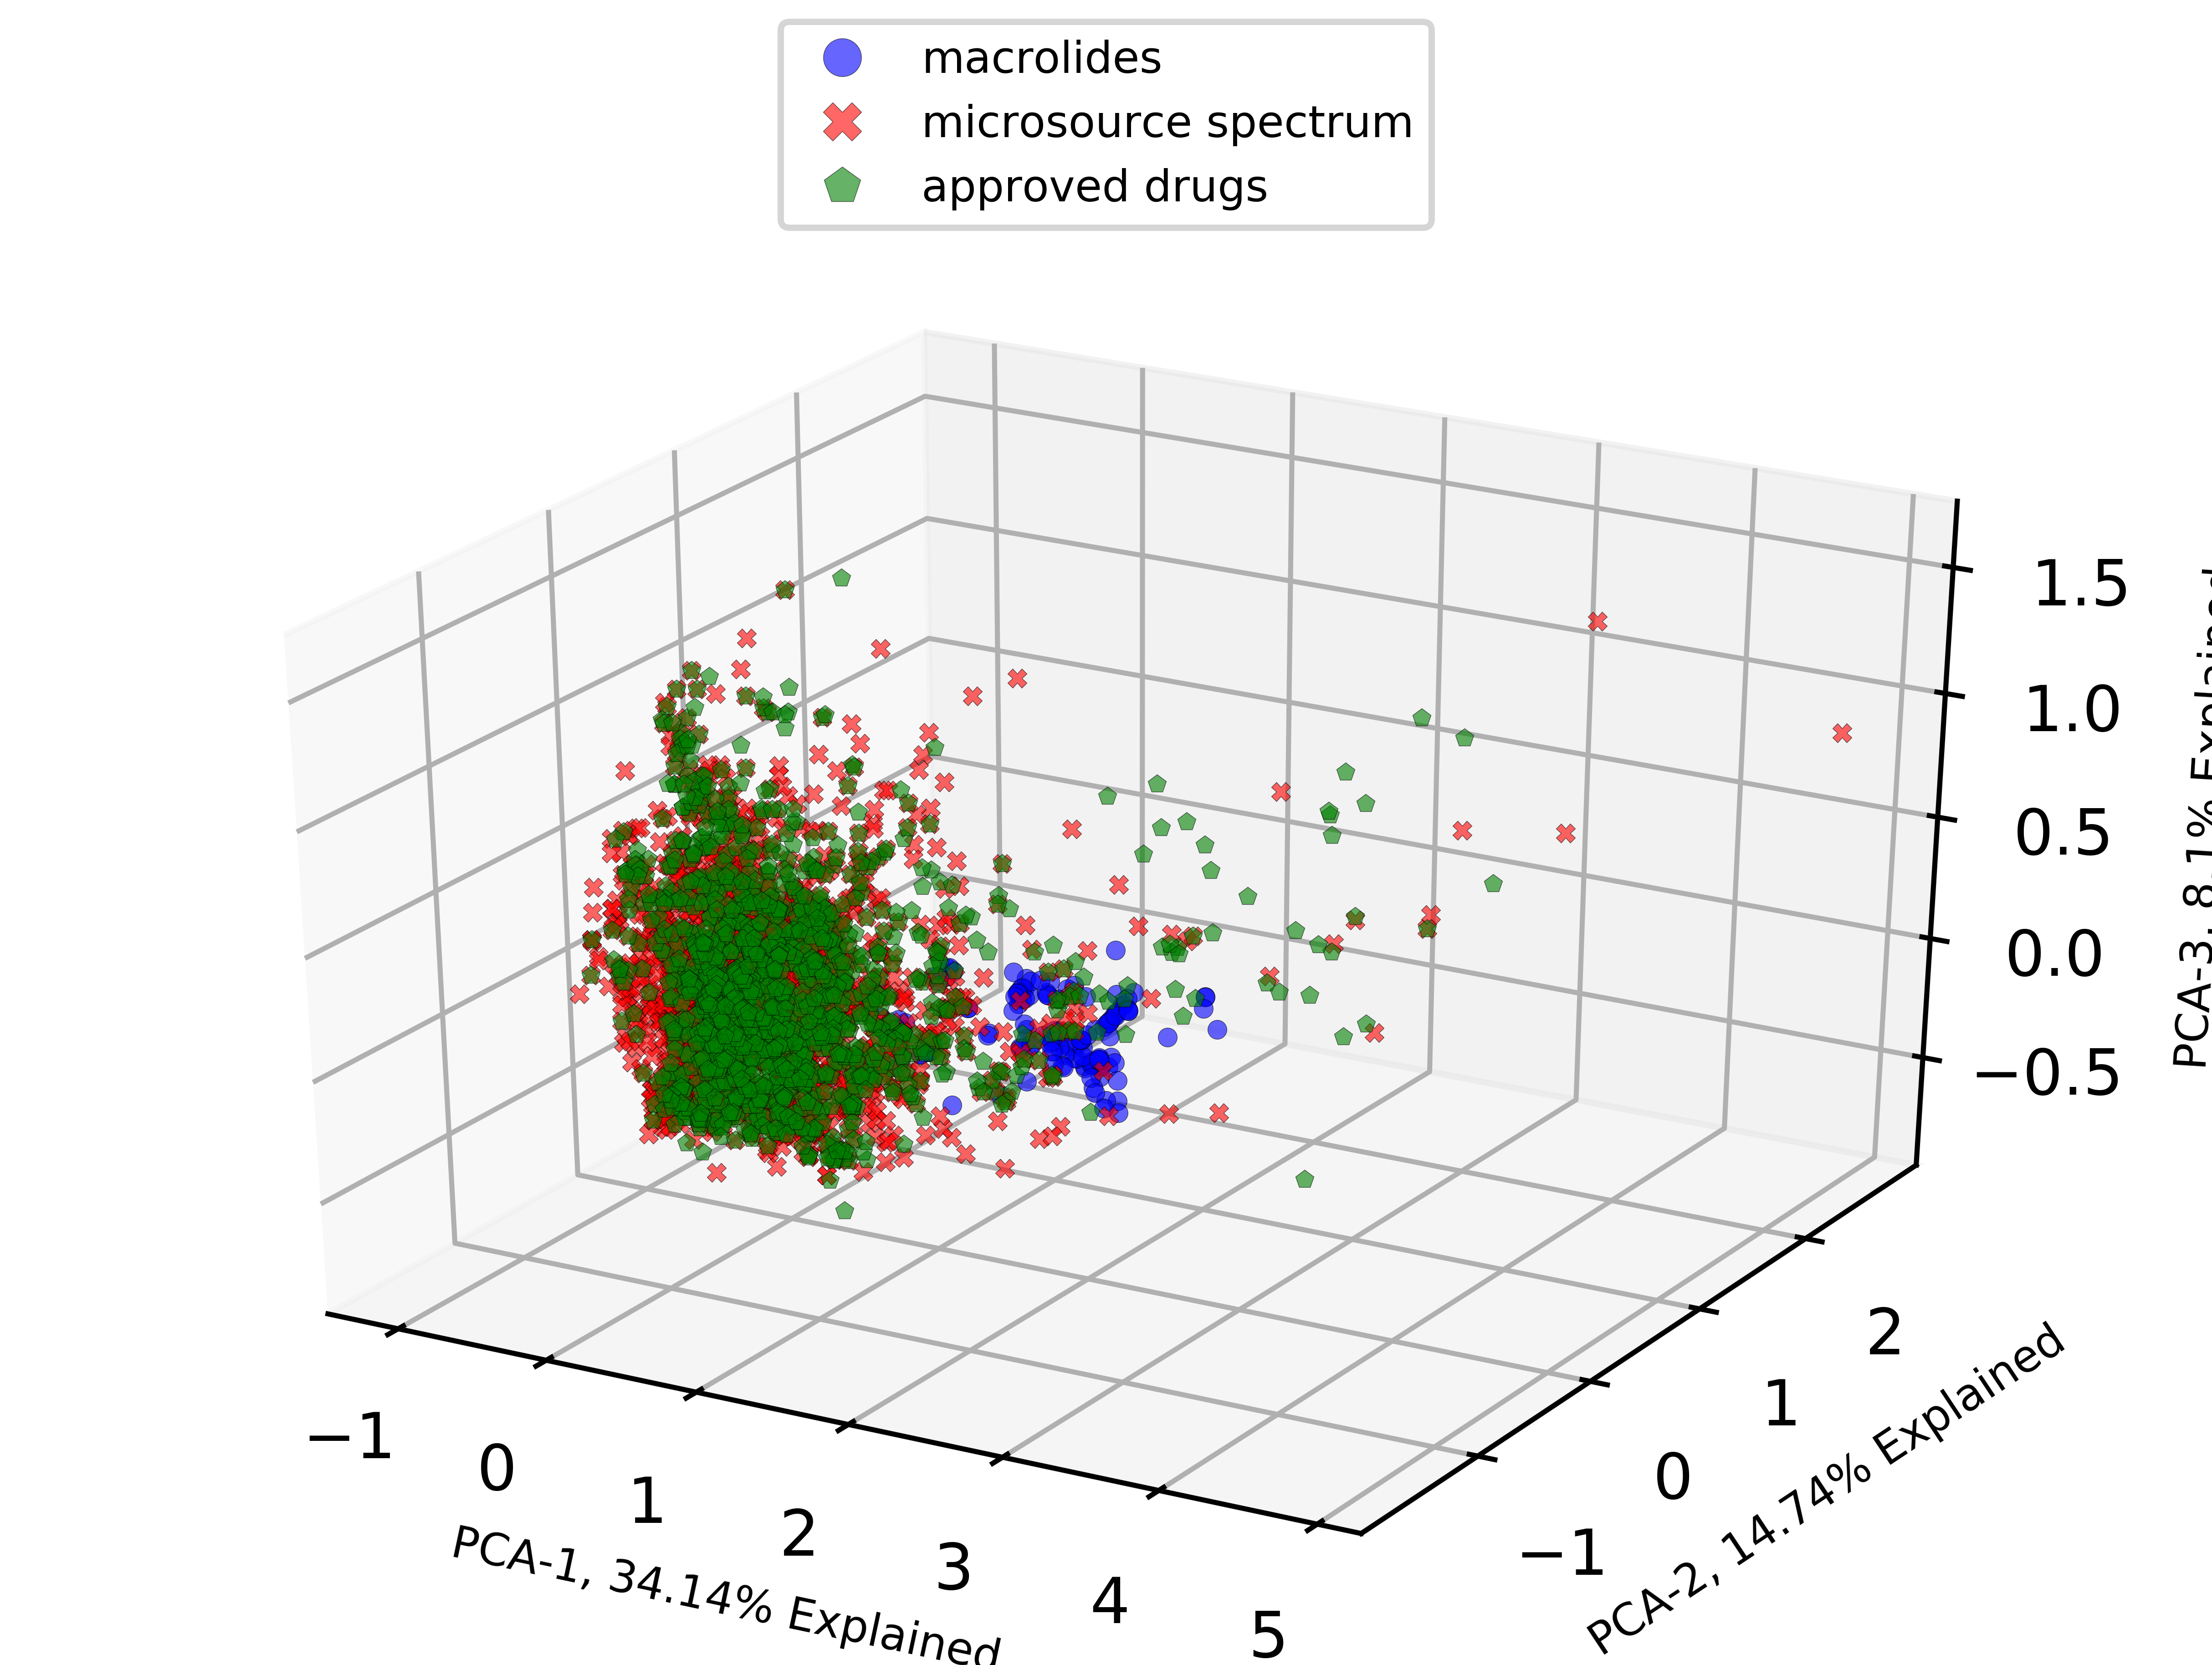

In [13]:
colors=['b', 'r', 'g']  # set three different colors to add to the PCA plot.

fig = plt.figure(1)

ax = fig.add_subplot(111, projection='3d')

# Let's set up the first dataset of actives_df. 
p1 = ax.plot(macrolides_df['pca-one'], 
             macrolides_df['pca-two'], 
             macrolides_df['pca-three'], 
             'o', color=colors[0],                                                 # set the first color 'b' for this dataset.
             alpha = 0.6, label='macrolides',                            # set the legend for this dataset as 'actives'
             markersize=3, 
             markeredgecolor='black',
             markeredgewidth=0.1)

# Let's set up the second dataset of micro_df.
p2 = ax.plot(micro_df['pca-one'], 
             micro_df['pca-two'], 
             micro_df['pca-three'], 
             'X', color=colors[1],                                                 # set the second color 'r' for this dataset. 
             alpha = 0.6, label='microsource spectrum',       # set the legend for this dataset as 'microsource spectrum'
             markersize=3, 
             markeredgecolor='black',
             markeredgewidth=0.1)

# Let's set up the third datset of approved_df.
p3 = ax.plot(approved_df['pca-one'], 
             approved_df['pca-two'], 
             approved_df['pca-three'], 
             'p', color=colors[2],                                                 # set the third color 'g' for this dataset.
             alpha = 0.6, label='approved drugs',                   # set the legend for this dataset as 'approved drugs'
             markersize=3, markeredgecolor='black',
             markeredgewidth=0.1)

# We will then label the three axes using the percentages explained for each major component.
ax.set_xlabel('PCA-1, ' +  str(round(pca.explained_variance_ratio_[0]*100,2)) + '% Explained', fontsize=7)
ax.set_ylabel('PCA-2, ' +  str(round(pca.explained_variance_ratio_[1]*100,2)) + '% Explained', fontsize=7)
ax.set_zlabel('PCA-3, ' +  str(round(pca.explained_variance_ratio_[2]*100,2)) + '% Explained', fontsize=7)


fig.legend(fontsize = 'x-small', loc='upper center', markerscale=2)
plt.autoscale()
plt.rcParams["figure.dpi"] = 1000                                   # set the figure resolution dpi value to 1000
plt.show()

fig_name = '3D_scatterplot_PCA.png'
fig.savefig(fig_name)